In [2]:
import os
import sys
import csv
import json
import moment
import pymysql
import datetime

import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

%matplotlib inline

## Create a plot to display rates of mortality and intubation across groups

In [3]:
# data_file_name = 'data/pandas_df_v3_2020-04-25.pkl'
# data_file_name = 'data/pandas_df_v3-1_2020-04-25.pkl'
# data_file_name = 'data/pandas_df_v3-1_2020-05-12.pkl'
data_file_name = 'data/pandas_df_v4_2020-04-25.pkl'

df = pd.read_pickle(data_file_name)
_version, date_retrieved = data_file_name.split('_df_')[1].split('.')[0].split('_')
print(_version, date_retrieved)

v4 2020-04-25


In [4]:
outcome = 'intubated'
days_to = 'days_to_intubation'
outcome_name = 'Intubation'

# outcome = 'died'
# days_to = 'days_to_death'
# outcome_name = 'Mortality'

In [7]:
covidpos = df.copy()

covidpos = covidpos[~pd.isna(covidpos["days_to_intubation"])]

# remove patients who were intubated before they were diagnosed
covidpos = covidpos[covidpos["days_to_intubation"] >= 0]

# remove patients that died before they were diagnosed
covidpos = covidpos[covidpos["days_to_death"] >= 0]

# remove patients who were intubated or died more than 30 days later
covidpos = covidpos[covidpos["days_to_intubation"] < 90]
covidpos = covidpos[covidpos["days_to_death"] < 90]

# add some binary age variables
covidpos['age_over_65'] = (covidpos['age'] > 65)+1-1

covidpos.describe()

,pat_mrn_id,intubated,days_to_intubation,died,days_to_death,age,sex,smoker,macula,compl_def,...,race_asian,race_white,race_other,race_declined,eth_hispanic,eth_nonhispanic,eth_declinedother,hx_data,co_data,age_over_65
count,6.393000e+03,6393.000000,6393.000000,6393.000000,6393.000000,6393.000000,6393.000000,2817.000000,6393.000000,6393.000000,...,6393.000000,6393.000000,6393.000000,6393.000000,6393.000000,6393.000000,6393.000000,6393.000000,6393.000000,6393.000000
mean,1.094742e+09,0.075708,19.596903,0.096668,19.983576,57.142709,0.496637,0.256656,0.013765,0.000626,...,0.023620,0.284374,0.278742,0.191303,0.341624,0.369936,0.288440,0.629282,0.680119,0.375411
std,1.318007e+08,0.264551,11.343829,0.295529,11.176388,19.885933,0.500028,0.436865,0.116523,0.025008,...,0.151873,0.451151,0.448416,0.393358,0.474291,0.482825,0.453072,0.483035,0.466467,0.484267
min,1.000011e+09,0.000000,0.000000,0.000000,0.000000,0.002738,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.004369e+09,0.000000,11.000000,0.000000,11.000000,41.470226,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.009216e+09,0.000000,20.000000,0.000000,20.000000,58.527036,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,1.200197e+09,0.000000,28.000000,0.000000,28.000000,72.005476,1.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.400038e+09,1.000000,84.000000,1.000000,83.000000,120.202601,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
def propci(p, n):
    s = np.sqrt((p*(1-p)/n))
    return (p, p-1.96*s, p+1.96*s)

In [9]:
covariates = [
    ('macula', 'Macula'),
    ('compl_def', 'Compl Deficiency'),
    ('coagulation', 'Coagulation' ),
    ('hypertension', 'Hypertension'),
    ('type2_diabetes', 'T2D'),
    ('obesity', 'Obesity'),
    ('cad', 'CAD'),
    ('sex', 'Sex (Male)'),
    ('age_over_65', 'Age (>65 yrs)'),
    ('refctrl', 'Cough')
]

results = list()

for covar, covar_name in covariates:
    p = covidpos[covidpos[covar]==1][outcome].mean()
    n = covidpos[covar].sum()
    p, plo, pup = propci(p, n)
    print(covar, n, p, plo, pup)
    
    results.append((p, plo, pup, n, covar_name))
    
results = sorted(results)

macula 88 0.1590909090909091 0.08267004554780864 0.23551177263400952
compl_def 4 0.0 0.0 0.0
coagulation 1239 0.1016949152542373 0.08486499855089076 0.11852483195758383
hypertension 1988 0.1056338028169014 0.09212219512820832 0.11914541050559449
type2_diabetes 911 0.12184412733260154 0.10060263677496299 0.14308561789024007
obesity 831 0.09265944645006016 0.07294495533608958 0.11237393756403075
cad 1698 0.11719670200235571 0.10189721400931696 0.13249618999539445
sex 3175 0.09669291338582676 0.0864127684382368 0.10697305833341673
age_over_65 2400 0.10125 0.08918110752285033 0.11331889247714969
refctrl 725 0.10482758620689656 0.08252895493952106 0.12712621747427205


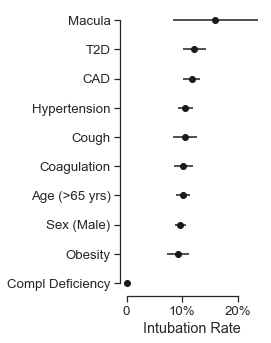

In [10]:
x = range(len(results))
y, ylo, yup, n, covar = zip(*results)

ylo = [yi-yj for yi, yj in zip(y, ylo)]
yup = [yj-yi for yi, yj in zip(y, yup)]

sns.set(style='ticks', font_scale=1.2)

plt.figure(figsize=(4,5))

plt.errorbar(y, x, xerr=[ylo, yup], fmt='ko', )

plt.xlabel('%s Rate' % outcome_name)
plt.yticks(x, covar, rotation=0)
plt.xticks([0, 0.1, 0.2], ['0', '10%', '20%'])
sns.despine(trim=True)

plt.tight_layout()

plt.savefig('figures/outcome_rates_%s_%s_%s.pdf' % (outcome, _version, date_retrieved))